# Slicing a MHD simulation with field lines

In [1]:
from pathlib import Path
import imageio

import numpy as np


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap

from tqdm.auto import tqdm

import astro3d
from astro3d.image_stack import makeslice
from astro3d.image_stack import VeroC_sRGB
from astro3d.image_stack import VeroM_sRGB
from astro3d.image_stack import VeroY_sRGB
from astro3d.image_stack import C_sRGB
from astro3d.image_stack import M_sRGB
from astro3d.image_stack import Y_sRGB

plt.style.use([{'image.cmap':'gray_r'}])

## Setup

### Read data

In [2]:
with np.load(astro3d.get_data('diskdata/rho.npz')) as f:
    data = f['arr_0'][()]
    
with np.load(astro3d.get_output('streamlines.npz'), allow_pickle=True) as f:
    streamlines = list(f['pathes'][()])

In [3]:
x = np.linspace(0, 1, data.shape[0])
y = np.linspace(0, 1, data.shape[1])
z = np.linspace(0, 1, data.shape[2])

### Printer settings

printer specific and layer thickness can be chosen to be different)

In [4]:
# these are the values for the J850 Prime
#dpi_x = 600
#dpi_y = 600
#dpi_z = 940  # 0.027 mm layer thickness

# these are the values used in alphacams TEILEFABRIK, where we ordered some of our prints
dpi_x = 600
dpi_y = 300
dpi_z = 940 # 0.027 mm layer thickness = 2.54 / dpi_z

Choose the height of the print, the rest should rescale accordingly

In [5]:
height = 5.0 # this should be the total height of the printed cube in cm

We distinguish between Vivid colors and the Rigid Colors. The Vivid colors are transparent and need to be mixed with white or black to make them intransparent.

In [6]:
vivid = True

### Output folder

We store the images in the path set by `output_dir`.

In [7]:
output_dir = 'slices_mhd' + vivid * '_vivid'

In [8]:
path = Path(astro3d.get_output()) / output_dir

if not path.is_dir():
    path.mkdir()
else:
    files = list(path.glob('slice*.png'))
    if len(files)>0:
        print('directory exists, deleting old files')
        for file in files:
            file.unlink()

directory exists, deleting old files


## New coordinates

calculate the new grids in x, y, z

In [9]:
#n_z = int(height / layer_thickness)
n_z = int(height * dpi_z / 2.54)

n_x = int(n_z * len(x) / len(z) / dpi_z * dpi_x)
n_y = int(n_z * len(y) / len(z) / dpi_z * dpi_y)

n_x += n_x%2 # add 1 to make it even if it isn't
n_y += n_y%2 # add 1 to make it even if it isn't

x2 = np.linspace(x[0], x[-1], n_x)
y2 = np.linspace(y[0], y[-1], n_y)
z2 = np.linspace(z[0], z[-1], n_z)

create an interpolation function for the non-normalized 3D data

In [10]:
def f_interp(coords):
    return astro3d._fortran.fmodule.interpolate(x, y, z, data, coords)

set the coordinates-tuple which is passed to the interpolation. x and y entries will stay the same and only the z entry will change.

Note that `coords` will not be passed to the interpolation function in this form, but will be transformed to a shape `(N, 3)`, where the number of points `N = len(x2) * len(y2)`.

In [11]:
coords = (x2, y2, z2)

## Normalization & color choices

Find the largest magnitude of the data values and define a logarithmic norm

In [12]:
dyn_range = 1e-4
vmax = data.max()
norm = LogNorm(dyn_range * vmax, vmax, clip=True)

define the density levels, their width, their colors, and the filling factors of the colors

In [13]:
levels = np.array([0.1, 0.4, 0.92])
# sigmas = np.array([0.03, 0.05, 0.03])
# clip = np.array([3.0, 5.0, 5.0])

sigmas = np.array([0.04, 0.04, 0.03])
clip = np.array([2.25, 4.0, 5.0])

# fill = np.array([0.1, 0.2, 1])     # this seemed too full
# fill = np.array([0.03, 0.06, 1.0]) # this seemed too empty
fill = np.array([0.08, 0.14, 0.5]) # also making the disk slightly less solid

We distinguish between Vivid colors and the Rigid Colors. The Vivid colors are transparent and need to be mixed with white or black to make them intransparent.

In [14]:
MidGreen = [1, 154, 106]

In [15]:
from astro3d.image_stack import rgb_to_cmyk
mg = rgb_to_cmyk(MidGreen)
mg[-1] = 1 - mg[-1]
mg /= mg.sum()
mg = np.round(mg * 100) / 100

In [16]:
# we add one extra color for the streamlines
White = np.ones(3)
if vivid:
    colors = [[Y_sRGB, White], [C_sRGB, White], [Y_sRGB, M_sRGB, White], [C_sRGB, Y_sRGB, White]]
    fmix   = [[0.8,    0.2  ], [0.8,    0.2  ], [0.4,    0.4,    0.2  ], [0.58,   0.22,   0.2  ]]
else:
    colors = [VeroY_sRGB, VeroC_sRGB, [VeroY_sRGB, VeroM_sRGB], VeroM_sRGB]
    fmix = [1, 1, [0.5, 0.5], 1]

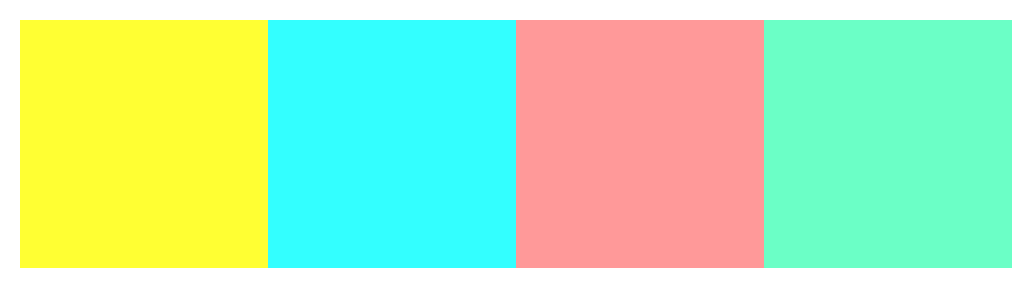

In [17]:
# show the mixed colors
mix = [(np.array(c, ndmin=2) * np.array(_f, ndmin=2).T).sum(0) for c, _f in zip(colors, fmix)]
plt.imshow([mix]).axes.axis('off');

Show a histogram of the data values

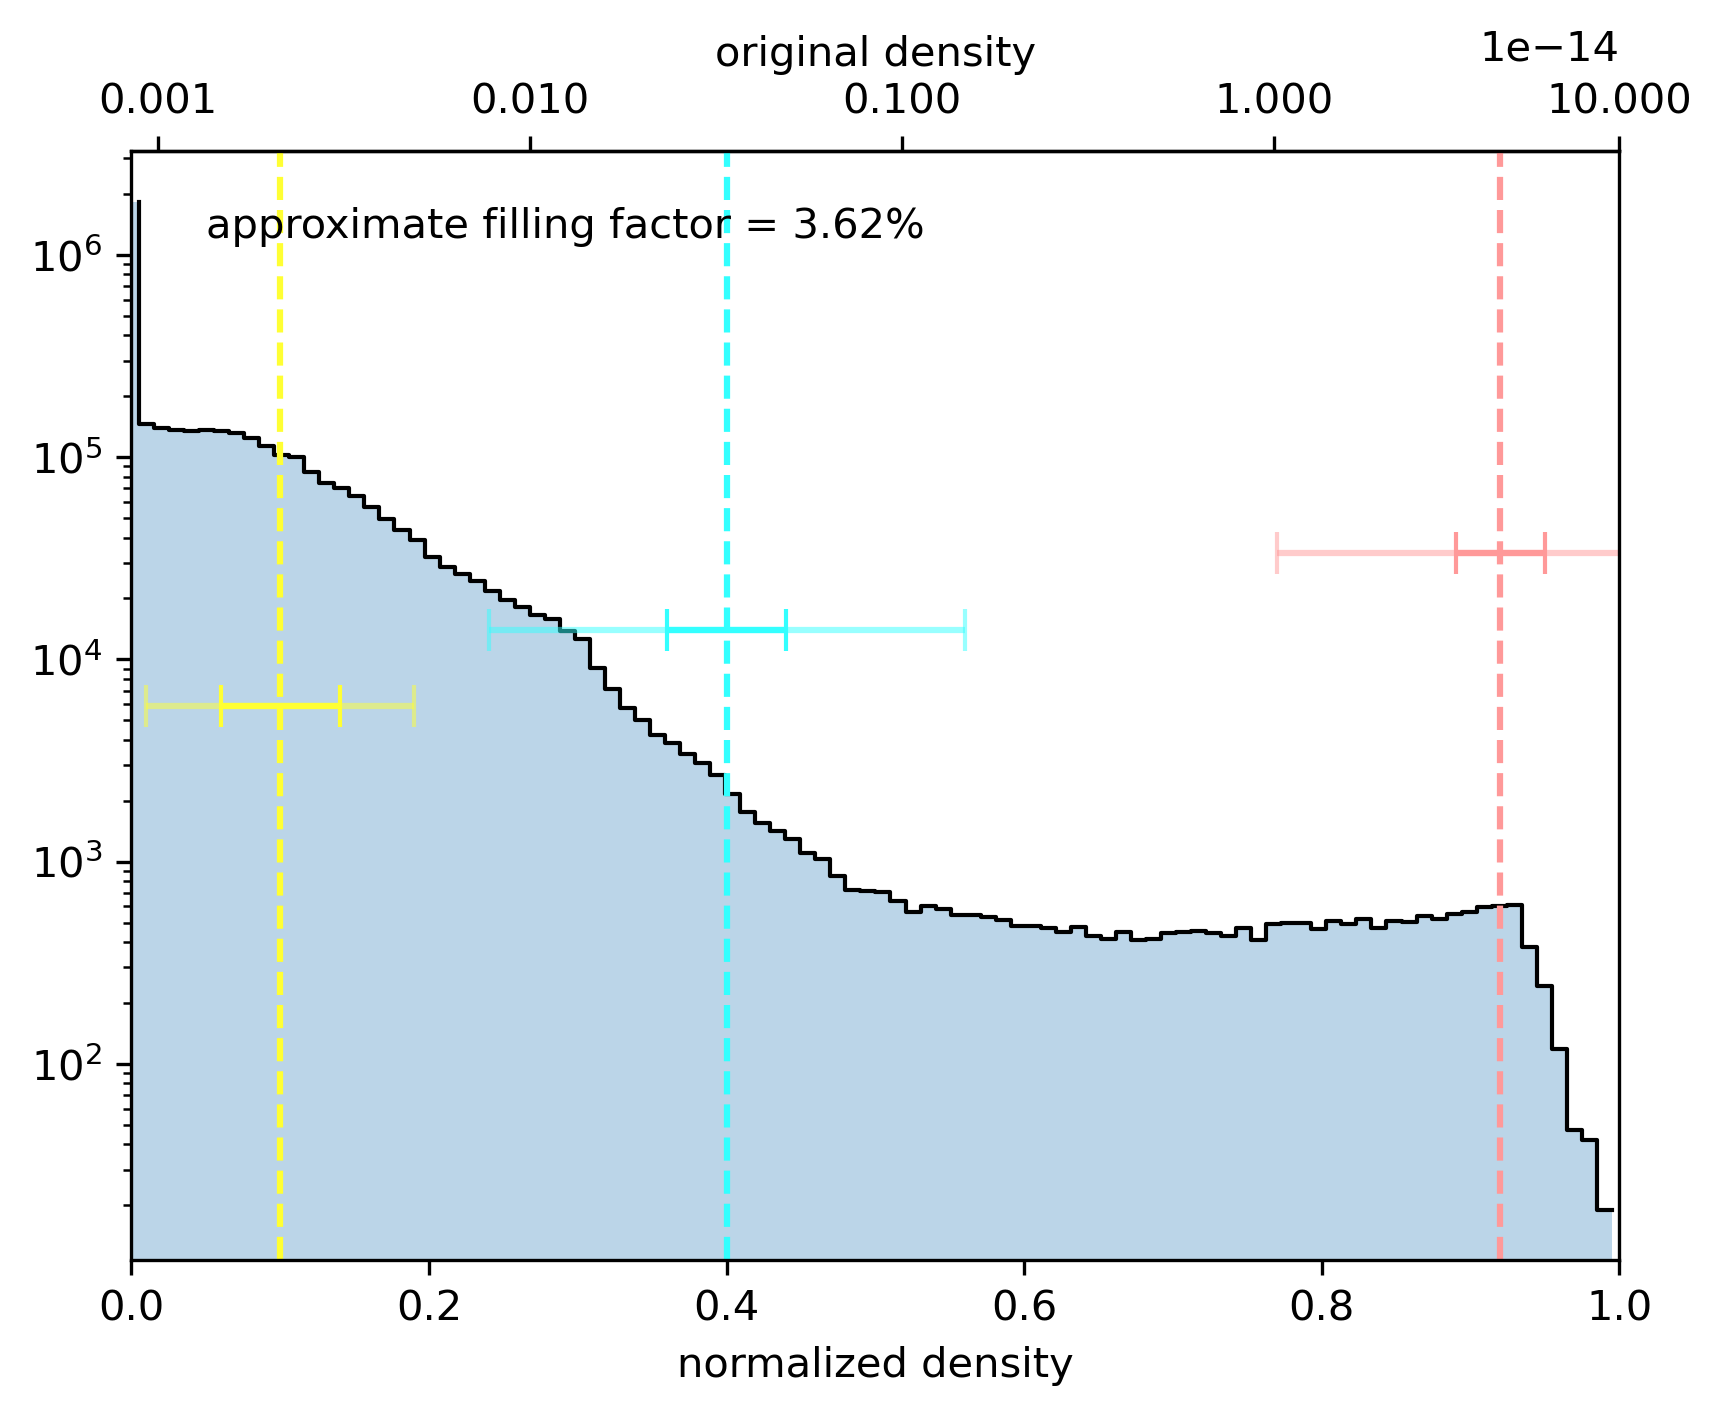

In [18]:
astro3d.image_stack.show_histogram(data, norm, colors=colors, levels=levels, sigmas=sigmas, clips=clip, f=fmix, fill=fill)

## Example slice

select which index in the new z-grid to process

In [19]:
iz = int(np.ceil(n_z / 2))

Process one slice and check the results

In [20]:
data_d, img = makeslice(iz, z2, f_interp, coords, norm, path,
                levels=levels, sigmas=sigmas, fill=fill,
                colors=colors, f=fmix, streamlines=streamlines, bg=0.8)

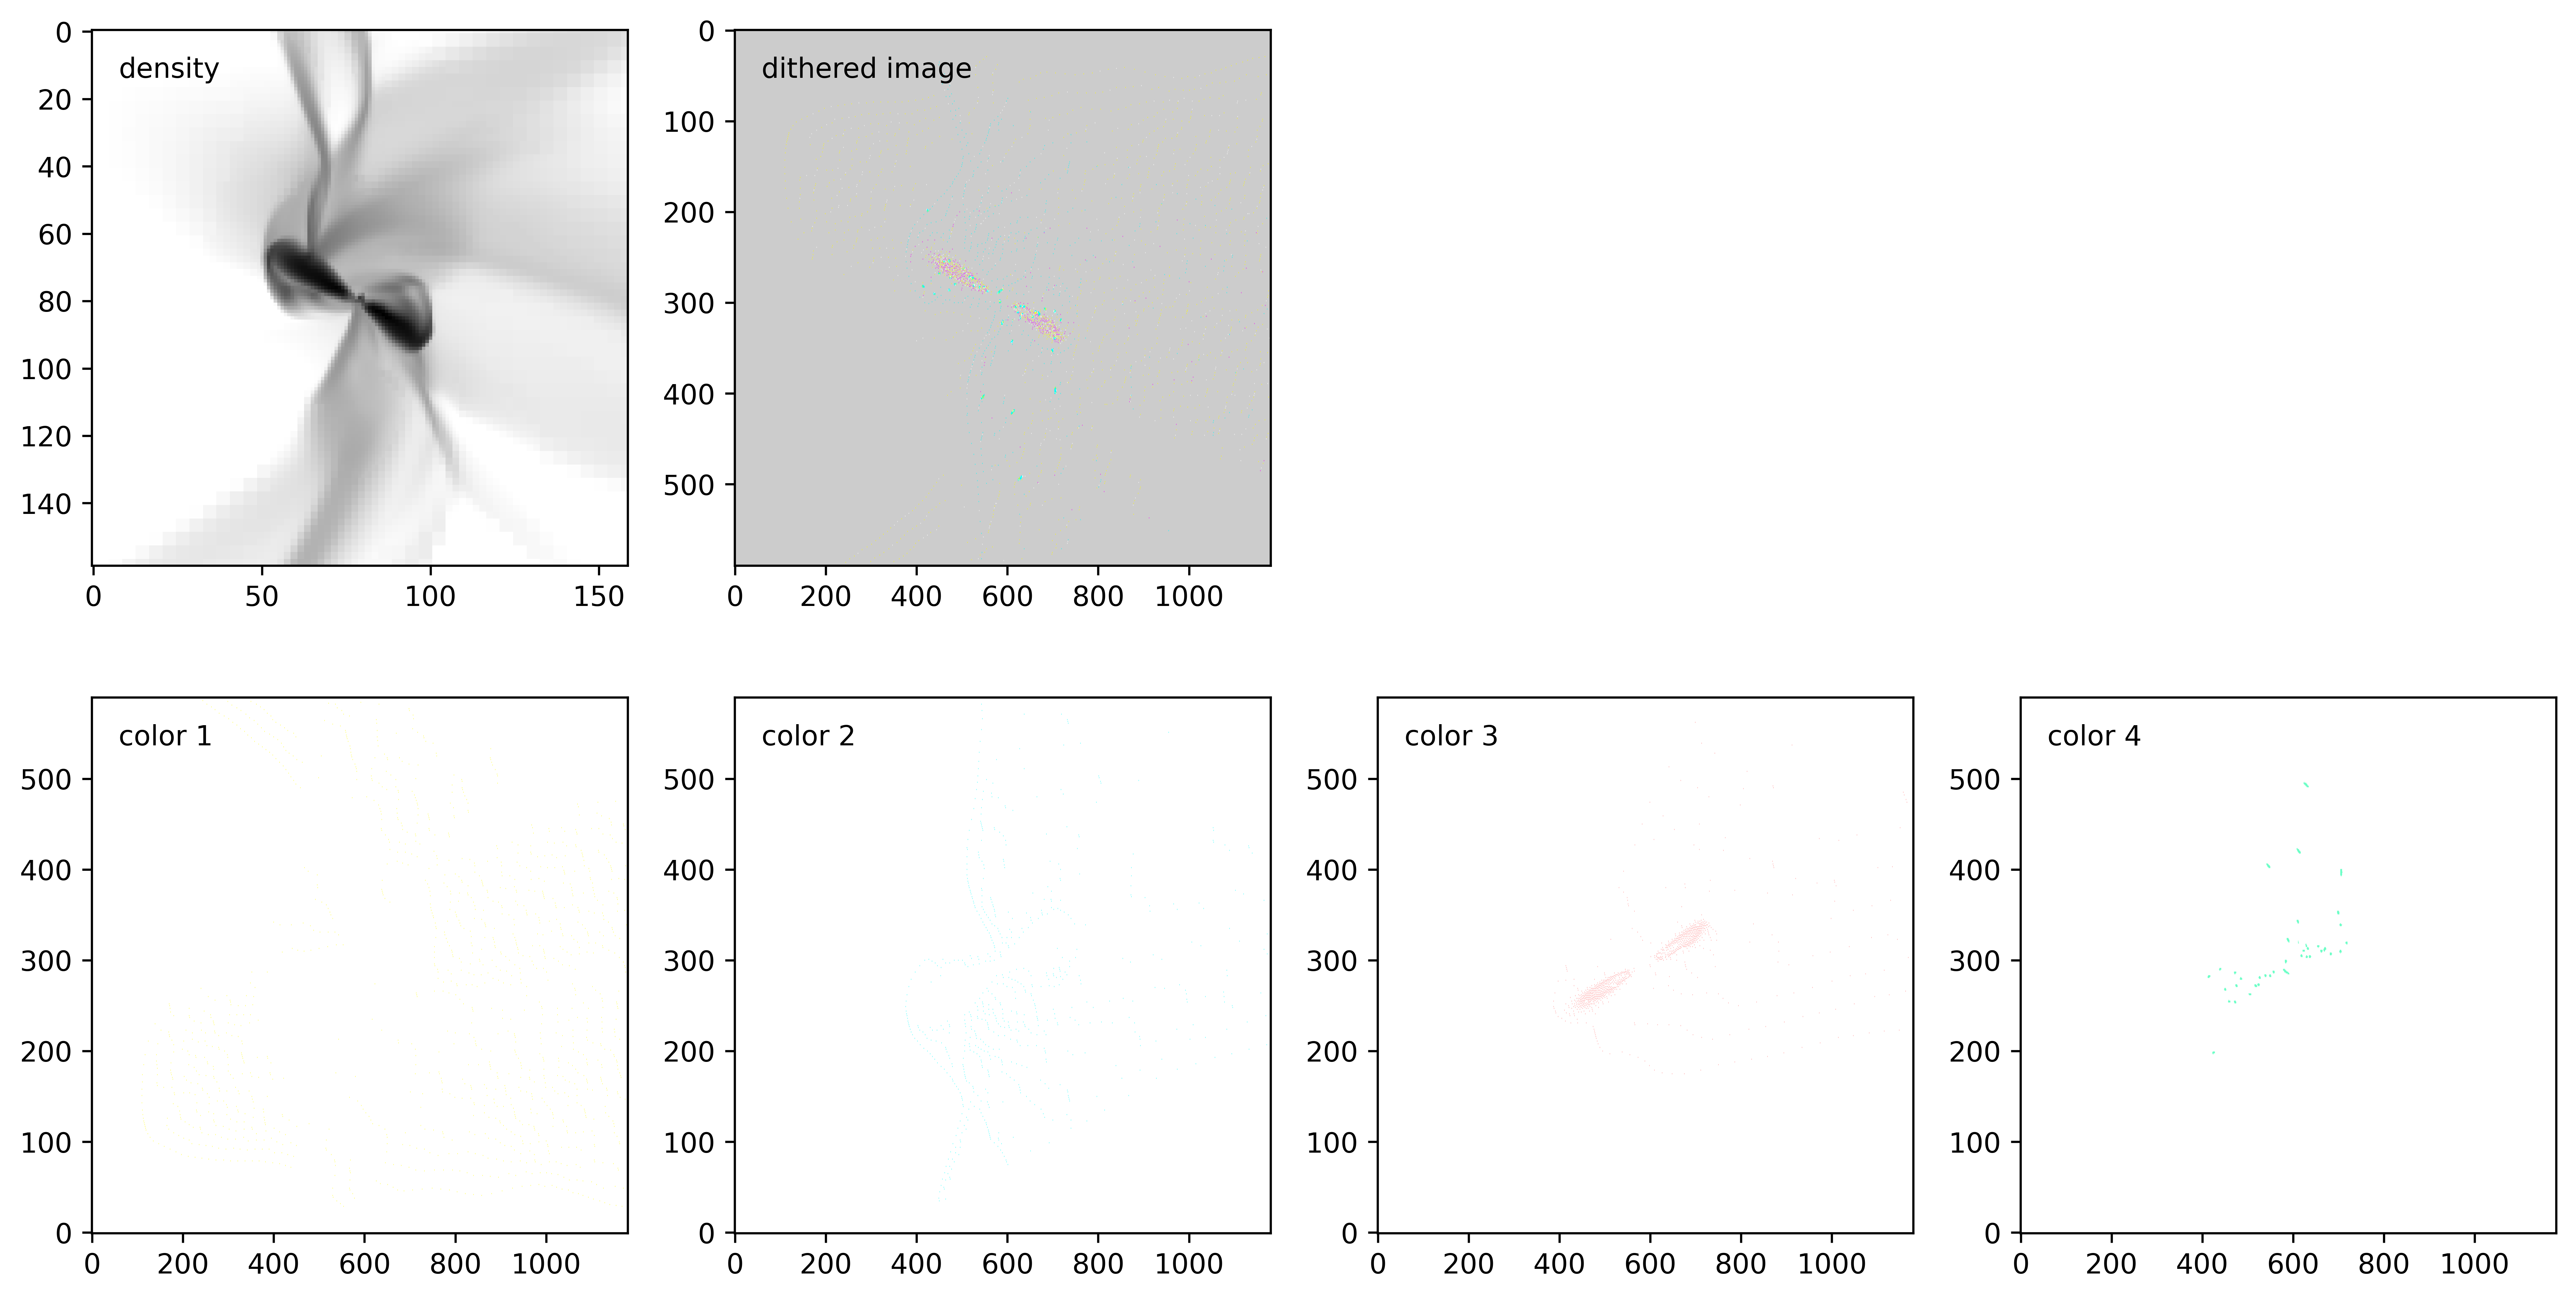

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=300)

axs[0,0].imshow(data[:, :, z.searchsorted(z2[iz])].T,norm=norm)
axs[0,0].text(0.05, 0.95, 'density', va='top', transform=axs[0,0].transAxes)

im = imageio.v2.imread(path / f'slice_{iz:04d}.png')
axs[0,1].imshow(im,norm=norm)
axs[0,1].set_aspect(dpi_x/dpi_y)
axs[0,1].text(0.05, 0.95, 'dithered image', va='top', transform=axs[0,1].transAxes)

axs[0,2].set_visible(False)
axs[0,3].set_visible(False)

for i, ax in enumerate(axs[1,:]):
    cmap = LinearSegmentedColormap.from_list('my', [[1,1,1], mix[i]])
    ax.imshow(data_d[:, :, i], origin='lower', cmap=cmap)
    ax.set_aspect(dpi_x/dpi_y)
    ax.text(0.05, 0.95, f'color {i+1}', va='top', transform=ax.transAxes)

## Iteration

In [22]:
iz = [0]  # Here we just want to print the first slice
# iz = np.arange(n_z)

In [23]:
for _iz in tqdm(iz):
    makeslice(_iz, z2, f_interp, coords, norm, path,
                    levels=levels, sigmas=sigmas, fill=fill,
                    colors=colors, f=fmix, streamlines=streamlines, bg=0.5)

  0%|          | 0/1 [00:00<?, ?it/s]